In [ ]:
!pip install torch.geometric

In [2]:
import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import numpy as np
import pandas as pd
import scipy.sparse as sp


from torch_geometric.datasets import Planetoid
import torch_geometric.utils
from torch_geometric.transforms import NormalizeFeatures

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score
from torch.optim import Adam
from tqdm import tqdm

from collections import defaultdict

import networkx as nx

### TSNE Visualizations

In [3]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


- We will take the cora citation network as input and will try to see the various features in the dataset

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch

dataset=Planetoid(root='data/Planetoid',name='Cora',transform=NormalizeFeatures())


#Lets explore the graph
dataset=dataset[0]
num_classes=torch.unique(dataset.y).shape[0]

print("Number of Graphs ", len(dataset))
print("Number of features ", dataset.num_features)
print("Number of classes ", num_classes)

#=====================================================

print("number of nodes \t", dataset.num_nodes)
print("number of edges \t", dataset.num_edges)
print("training mask \t", dataset.train_mask.sum())
print("validation mask \t", dataset.val_mask.sum())
print("test mask \t", dataset.test_mask.sum())

print("Does the graph contains isolated nodes \t", dataset.has_isolated_nodes())
print("Does the graph contains self loops \t", dataset.has_self_loops())
print("is the graph undirected \t", dataset.is_undirected())

# feature matrix X
print("features of the graph \t", dataset.x.shape)

# class labels
print("labels of the nodes \t", dataset.y.shape)

# structural information
print("List of edges in the graph \t", dataset.edge_index.shape)

Processing...
Done!


Number of Graphs  6
Number of features  1433
Number of classes  7
number of nodes 	 2708
number of edges 	 10556
training mask 	 tensor(140)
validation mask 	 tensor(500)
test mask 	 tensor(1000)
Does the graph contains isolated nodes 	 False
Does the graph contains self loops 	 False
is the graph undirected 	 True
features of the graph 	 torch.Size([2708, 1433])
labels of the nodes 	 torch.Size([2708])
List of edges in the graph 	 torch.Size([2, 10556])


### Define The GCN Network

In [5]:
device='cuda'

if 'cuda'==device:
    torch.cuda.manual_seed(30)
else:
    torch.manual_seed(30)

In [6]:
class GraphConvolution(nn.Module):

    def __init__(self,in_features,out_features,bias=True):
        super(GraphConvolution,self).__init__()
        self.in_features=in_features
        self.out_features=out_features
        self.weight=Parameter(torch.FloatTensor(in_features,out_features).to(device=device))

        if bias:
            self.bias=Parameter(torch.FloatTensor(out_features).to(device=device))
        else:
            self.register_parameter(bias,'None')

        self.reset_parameter()

    #Xavier Initialization
    def reset_parameter(self):
        stdv=1./math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv,stdv).to(device=device)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv,stdv).to(device=device)

    def forward(self,input,adj):
        support=torch.mm(input,self.weight).to(device=device)
        output=torch.mm(adj,support).to(device=device)
        if self.bias is not None:
            return output+self.bias
        return self.bias

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
      super(GCN, self).__init__()
      self.gc1 = GraphConvolution(nfeat, nhid)
      self.gc2 = GraphConvolution(nhid, nclass)
      self.dropout = dropout

    def forward(self,x,adj):
        x=F.relu(self.gc1(x,adj)).to(device=device)
        x=F.dropout(x,self.dropout,training=self.training).to(device=device) #Training mode drop out will be disabled
        x=self.gc2(x,adj).to(device=device)
        return F.log_softmax(x,dim=1)

In [8]:
def normalize(matrix,beta=0.5):
    rowsum = torch.sum(matrix,dim=1).to(device=device)
    r_inv =  torch.pow(rowsum, -beta).flatten()
    r_inv[torch.isinf(r_inv)] = 0
    D = torch.diag(r_inv).to(device=device)
    matrix=torch.mm(D,matrix).to(device=device)
    matrix=torch.mm(matrix,D).to(device=device)
    return matrix

### Define The Adjacency Matrix

In [9]:
def Build_Adjacency_Matrix(beta):

    features = dataset.x.to(device)  # No need for sparse -> dense conversions

    #features=Add_degree_centrality(data).to(device=device)

    labels=dataset.y.to(device=device)

    #build the graph
    nodes,edges=dataset.x.shape[0],dataset.edge_index
    A=torch.zeros(nodes,nodes,dtype=torch.float32).to(device=device)

    for e in range(edges.shape[1]):
      source=edges[0][e]
      target=edges[1][e]
      A[source][target]=1.

    A=A+torch.eye(nodes,dtype=torch.float32).to(device=device)
    A=normalize(A,beta).to(device=device)


    idx_train = dataset.train_mask
    idx_val = dataset.val_mask
    idx_test = dataset.test_mask

    return A, features, dataset, labels, idx_train, idx_val, idx_test


### Define The Model & Parameters

In [18]:
epoches=200
no_of_iter=10
nhid=16
dropout=0.5
lr=0.01
decay=5e-4
model=GCN(dataset.x.shape[1],nhid,num_classes,dropout)
optimizer=Adam(model.parameters(),lr=lr,weight_decay=decay)

## Define The Training Loop Over Multiple Layers

In [14]:
def train(model,optimizer,input,A,train_mask,labels):
  model.train() #Set the model in training mode
  optimizer.zero_grad() #Clear the gradients and set it to zero
  y_pred=model(input,A) #Forward Pass
  loss_train=F.nll_loss(y_pred[train_mask],labels[train_mask].to(device=device)) #Calculate the loss in training mode
  loss_train.backward() #Compute the gradients
  optimizer.step() #Update the parameters
  return loss_train.item() #Return the loss

### Define The Test Method

In [15]:
#Testing Loop
def test(model,input,A,test_mask,label,best_model=None):
  if best_model is not None:
    model.load_state_dict(best_model)
    model.eval()
    y_out=model.forward(input,A)
    y_pred=torch.argmax(y_out,dim=1)
    y_true=label[test_mask].cpu().numpy()
    y_pred=y_pred[test_mask].cpu().numpy()
    return accuracy_score(y_pred,y_true)
    #return precision_score(y_pred,y_true,average='weighted')

  model.eval()  #Setting the model to evaluation mode
  y_out=model.forward(input,A) #Forward Pass
  y_pred=torch.argmax(y_out,dim=1) #Get the highest predicted class label

  #Convert the predicted and the true label to numpy for score calculation
  y_true=label[test_mask].cpu().numpy()
  y_pred=y_pred[test_mask].cpu().numpy()

  #Calculate the scores
  #print(f"Accuracy Score:{accuracy_score(y_pred,y_true)}")
  return accuracy_score(y_pred,y_true)
  #return precision_score(y_pred,y_true,average='weighted')

### Embedding visualization before training of The Model

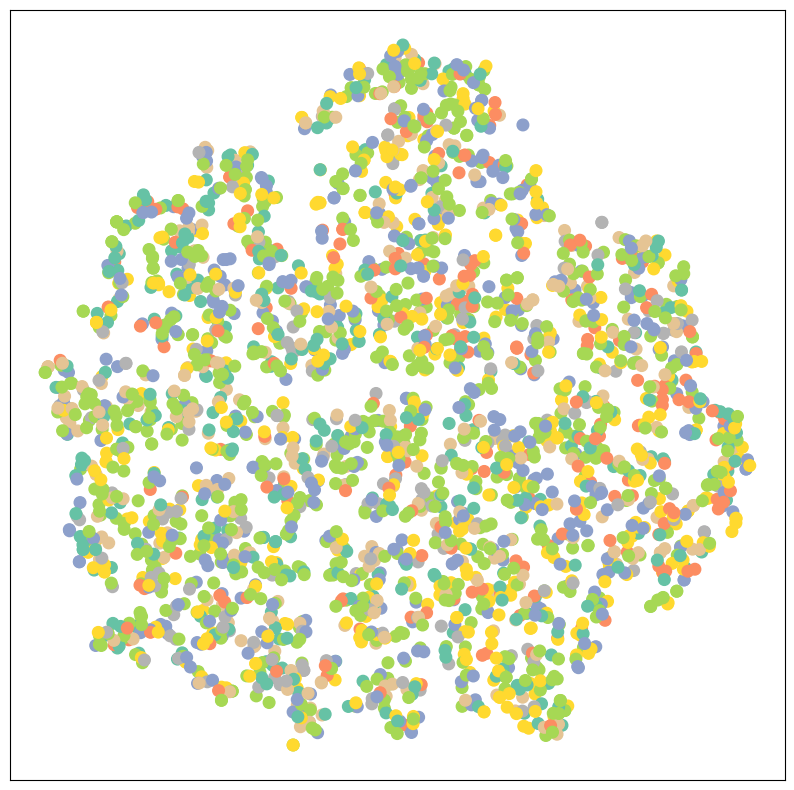

In [19]:
# output from the untrained gcn
A, features, dataset, labels, idx_train, idx_val, idx_test=Build_Adjacency_Matrix(0.5)
out = model.forward(features,A)
visualize(out, color=dataset.y)

### Perform Training And Validation On The Model

In [27]:
test_accuracy,best_model=[],None
Mean_test_accuracy,test_acc_standard_dev=None,None
for noi in range(no_of_iter):
    best_val_acc=0
    print() #Adding one line space
    print("Training Started")
    print('-'.join('' for _ in range(100)))
    for e in tqdm(range(epoches),desc="Training Progress"):
        train_loss=train(model,optimizer,features,A,idx_train,labels)
        #print(f"Training Loss for Epoch {e+1} : {train_loss}")
        val_acc=test(model,features,A,idx_val,labels)
        #print(f"Validation Accuracy for Epoch {e+1} : {val_acc}")
        if(val_acc>best_val_acc):
            best_val_acc = val_acc
            best_model=model.state_dict()
    test_accuracy.append(test(model,features,A,idx_test,labels,best_model=best_model))
test_accuracy=np.array(test_accuracy)
Mean_test_accuracy=np.mean(test_accuracy)
test_acc_standard_dev=np.std(test_accuracy)
print('-'.join('' for _ in range(100)))
print(f"Mean Accuracy :",Mean_test_accuracy)
print(f"Standard Deviation Of Accuracy Values:",test_acc_standard_dev)


Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 255.38it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 269.87it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 268.68it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 274.21it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 266.10it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 269.68it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 264.38it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:00<00:00, 270.00it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:01<00:00, 149.77it/s]



Training Started
---------------------------------------------------------------------------------------------------


Training Progress: 100%|██████████| 200/200 [00:02<00:00, 84.66it/s]

---------------------------------------------------------------------------------------------------
Mean Accuracy : 0.8128
Standard Deviation Of Accuracy Values: 0.0035721142198983096


### TSNE Plot After Training The Model

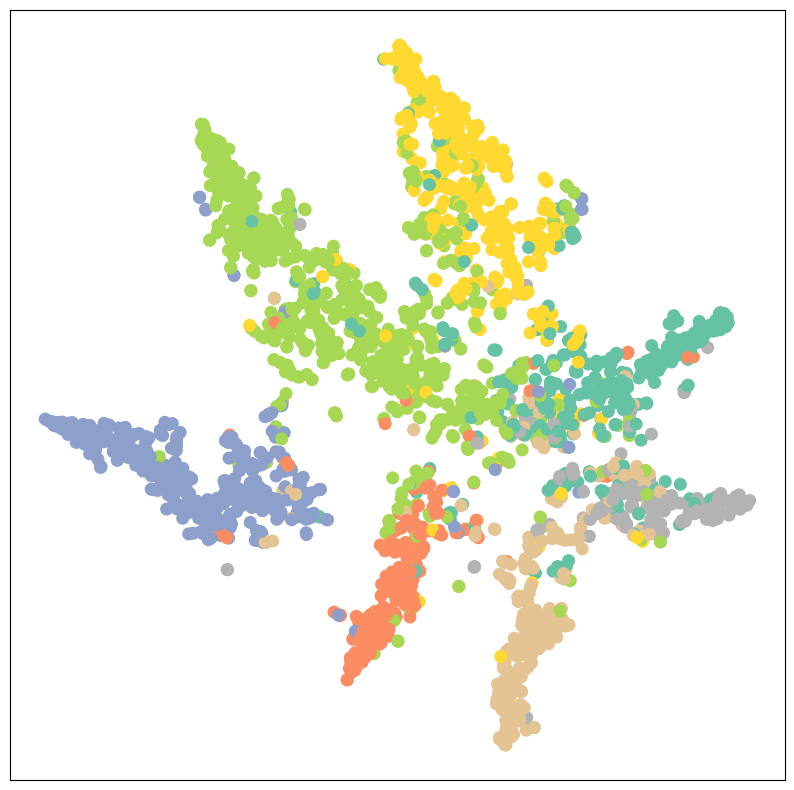

In [29]:
# visualizing node embeddings after training
model.load_state_dict(best_model)
model.eval()
out = model.forward(features,A)
visualize(out, color=dataset.y)